1. place-based search for "Savannah" and "Tybee" in the Matthew keyword data (we already have these data from Jennings a few months ago)
2. geotagged data in Savannah and Tybee, from the geotagged data set Jennings collected (not Matthew keyword -- all geotagged data)

Jennings- For #2, can you define an area around Savannah and Tybee Island and filter to that fairly easily? How big would that data set be? Or would you suggest another approach, if he wants to look at data from that area that doesn't depend on keywords?

First, need geometries for Savannah and Tybee Island
(The geotagged data is in the windswath regions)

In [2]:
import os, gzip, json, sys, time
from pprint import pprint
import pandas as pd
from multiprocessing import Pool, Manager
from bson import json_util

In [13]:
# Path where gnip files are stored
output_file = '/data/hyperlocal/hurricane_matthew/all_geo_windswath'
paths = ['/data/chime/matthew/gnip-geo/ws1','/data/chime/matthew/gnip-geo/ws2','/data/chime/matthew/gnip-geo/ws3']

In [28]:
files = []
for p in paths:
    files += [p+"/" + x for x in os.listdir(p)]
files.sort()
print("Found {0} files, first 5:".format(len(files)))
files[:5]

Found 33486 files, first 5:


['/data/chime/matthew/gnip-geo/ws1/f31wsc2nvq_2016_08_01_00_00_activities.json.gz',
 '/data/chime/matthew/gnip-geo/ws1/f31wsc2nvq_2016_08_01_00_10_activities.json.gz',
 '/data/chime/matthew/gnip-geo/ws1/f31wsc2nvq_2016_08_01_00_20_activities.json.gz',
 '/data/chime/matthew/gnip-geo/ws1/f31wsc2nvq_2016_08_01_00_30_activities.json.gz',
 '/data/chime/matthew/gnip-geo/ws1/f31wsc2nvq_2016_08_01_00_40_activities.json.gz']

## Load the files

In [31]:
def read_file_and_write(inFile, openFile):
    '''
    Input   (inFile (gzipped), openFile (to write to))
    Returns (None)
    '''
    tweets = []
    deadlines = 0
    metadata = None

    with gzip.open(inFile, 'rb') as f:
        file_content = f.read().decode("utf-8") #read in file as string
        list_tweets = file_content.split("\n")  #split string into list of individual tweets
        for t in list_tweets:
            try:
                json_tweet = json.loads(t)                    
                if 'info' in json_tweet:
                    metadata = json_tweet
                else:                
                    json_tweet['datetime'] = pd.Timestamp(json_tweet['postedTime'])
                    tweets.append(json_tweet)
            except:
                deadlines+=1

    #Ensure the tweets are sorted by time?
    sys.stderr.write("...sorting...")
    tweets.sort(key=lambda t: t['datetime'])
        
    for t in tweets:
        openFile.write(json.dumps(t,default=json_util.default)+"\n")
    
    logFile.write("Tweets: {0}, {1}, {2}\n".format(len(tweets), json.dumps(metadata), str(deadlines)))

In [32]:
logFile = open('/data/chime/matthew/all-geo-windswath-extract.log','w')

In [ ]:
with open(output_file+'.jsonl','w') as outFile:
    for idx, file in enumerate(files):
        read_file_and_write(file, outFile)
        sys.stderr.write("\r"+str(idx))
logFile.close()

2384

# Read `.jsonl` file back in?

In [ ]:
idx = 0;
limit = 100
tweets = []
with open('/data/chime/matthew/all_geo_windswath.jsonl','r') as jsonl_file:
    for line in jsonl_file:
        tweets.append( json.loads(line) )
        
        idx += 1
        sys.stderr.write("\r"+str(idx))
#         if idx > limit: 
#             break
df = pd.DataFrame(tweets)
len(df)

3322805

In [ ]:
from shapely import geometry
import numpy as np

In [ ]:
# df.head(5).location.apply(lambda x: pprint(x))

In [ ]:
def extractGeometry(row):
    #Best case scenario: There is a point coordinate: prioritize these data
    if pd.notnull(row.geo):
        row.geo['coordinates'].reverse()
        return row.geo
    else:
        if pd.notnull(row.location):
            if row.location['twitter_place_type'] != 'admin':
                if row.location['geo']['type'] == "Point":
                    return row.location['geo']
                else:
                    if len(row.location['geo']['coordinates'][0]) == 4:
                        row.location['geo']['coordinates'][0].append(row.location['geo']['coordinates'][0][0])
                    return row.location['geo']

In [ ]:
df['geojson'] = df.apply(lambda row: extractGeometry(row), axis=1)

In [ ]:
pd.notnull(df.geojson).all()

True

In [ ]:
df.head(10).geojson.apply(lambda x: print(json.dumps(x)))

{"type": "Polygon", "coordinates": [[[-81.922577, 32.148875], [-81.922577, 32.176624], [-81.893419, 32.176624], [-81.893419, 32.148875], [-81.922577, 32.148875]]]}
{"type": "Polygon", "coordinates": [[[-80.331893, 27.120371], [-80.331893, 27.210603], [-80.251798, 27.210603], [-80.251798, 27.120371], [-80.331893, 27.120371]]]}
{"type": "Polygon", "coordinates": [[[-80.150481, 33.010484], [-80.150481, 33.042398], [-80.109619, 33.042398], [-80.109619, 33.010484], [-80.150481, 33.010484]]]}
{"type": "Polygon", "coordinates": [[[-81.326884, 28.658956], [-81.326884, 28.730516], [-81.208792, 28.730516], [-81.208792, 28.658956], [-81.326884, 28.658956]]]}
{"type": "Point", "coordinates": [-76.38789058, 37.00937833]}
{"type": "Polygon", "coordinates": [[[-80.706074, 28.03509], [-80.706074, 28.200658], [-80.593324, 28.200658], [-80.593324, 28.03509], [-80.706074, 28.03509]]]}
{"type": "Point", "coordinates": [-77.03889098, 34.66509465]}
{"type": "Polygon", "coordinates": [[[-81.285896, 28.84511]

0    None
1    None
2    None
3    None
4    None
5    None
6    None
7    None
8    None
9    None
Name: geojson, dtype: object

In [ ]:
df['geometry'] = df.geojson.apply(lambda g: geometry.shape(g))

In [ ]:
df.head(10).geometry

0    POLYGON ((-81.922577 32.148875, -81.922577 32....
1    POLYGON ((-80.33189299999999 27.120371, -80.33...
2    POLYGON ((-80.150481 33.010484, -80.150481 33....
3    POLYGON ((-81.32688400000001 28.658956, -81.32...
4                     POINT (-76.38789058 37.00937833)
5    POLYGON ((-80.706074 28.03509, -80.706074 28.2...
6               POINT (-77.03889098000001 34.66509465)
7    POLYGON ((-81.28589599999999 28.84511, -81.285...
8                     POINT (-80.03338164 32.87707939)
9                             POINT (-81.3758 28.5335)
Name: geometry, dtype: object

In [ ]:
pd.notnull(df.geometry).all()

True

# Now check the neighborhoods against the DataFrame

1. Savannah
1. Tybee

In [123]:
tybee =  {
    "type": "Polygon",
    "coordinates": [ [
        [-80.89831653639936,32.0084957931768],
        [ -80.85206251542532, 32.04586355296081],
        [ -80.82296508005318, 32.00693318137794],
        [ -80.8510462114716, 31.969074767576263],
        [ -80.89831653639936, 32.0084957931768]
       ]]}

savannah = { "type": "Polygon",
"coordinates": [[[-81.370276,32.080956],
        [-81.370391, 32.081213],
        [-81.294246, 32.166137],
        [-81.279687, 32.176734],
        [-81.2775193, 32.1783063],
        [-81.27238, 32.1819238],
        [-81.266032, 32.1859062],
        [-81.2655971,32.1861401],
        [-81.2651941, 32.1862921],
        [-81.25942, 32.1878979],
        [-81.2588901, 32.1880369],
        [-81.25639039999999, 32.1886598],
        [-81.2496125,32.1899946],  
        [-81.2469189,32.1899526],   
        [-81.24380829999998,32.1892917],   
        [-81.239605,32.1880479],   
        [-81.2361885,32.186843],   
        [-81.2352306,32.1865051],
        [-81.2263759,32.1832796],  
        [-81.1869159,32.1653553],   
        [-81.045061,32.082862],   
        [-81.030166,32.050784],   
        [-81.092455,31.891374],   
        [-81.09645,31.890464],   
        [-81.10826,31.887867],   
        [-81.112658,31.887691],
        [-81.119876,31.888527],   
        [-81.123748,31.889553],   
        [-81.307569,31.982019],   
        [-81.307956,31.982389],   
        [-81.30823,31.982746],   
        [-81.369981,32.080426],   
        [-81.370276,32.080956]]]}

In [124]:
tybee_geom = geometry.shape(tybee)
sav_geom   = geometry.shape(savannah)

In [ ]:
tybee_tweets = df[df.geometry.apply(lambda x: x.intersects(tybee_geom))]
len(tybee_tweets)

3879

In [ ]:
tybee_tweets.head()

,actor,body,datetime,display_text_range,favoritesCount,generator,geo,gnip,id,inReplyTo,...,postedTime,provider,retweetCount,twitter_entities,twitter_extended_entities,twitter_filter_level,twitter_lang,verb,geojson,geometry
119,"{'favoritesCount': 17910, 'postedTime': '2012-...",Her first time at the beach 😍🌴🐟💦 https://t.co/...,{'$date': 1470009928000},NaN,0,"{'link': 'http://twitter.com/download/iphone',...",NaN,"{'matching_rules': [{'tag': 'id:282,radii:64,c...","tag:search.twitter.com,2005:759902835643445248",NaN,...,2016-08-01T00:05:28.000Z,"{'link': 'http://www.twitter.com', 'objectType...",0,"{'media': [{'url': 'https://t.co/TLPnCB4j4M', ...","{'media': [{'url': 'https://t.co/TLPnCB4j4M', ...",low,en,post,"{'type': 'Polygon', 'coordinates': [[[-80.8834...","POLYGON ((-80.88342 31.98701, -80.88342 32.028..."
255,"{'favoritesCount': 3687, 'postedTime': '2012-0...","Stung by a jellyfish &amp; sunburned on day 1,...",{'$date': 1470010282000},NaN,0,"{'link': 'http://instagram.com', 'displayName'...","{'type': 'Point', 'coordinates': [-80.84944444...","{'urls': [{'url': 'https://t.co/ANXF1hWD54', '...","tag:search.twitter.com,2005:759904319940415488",NaN,...,2016-08-01T00:11:22.000Z,"{'link': 'http://www.twitter.com', 'objectType...",0,"{'urls': [{'url': 'https://t.co/ANXF1hWD54', '...",NaN,low,en,post,"{'type': 'Point', 'coordinates': [-80.84944444...",POINT (-80.84944444 32.00666667)
1930,"{'favoritesCount': 8292, 'postedTime': '2011-1...",@KMHUG @FemaleStruggIes relatable x100 😂😂,{'$date': 1470013971000},NaN,0,"{'link': 'http://twitter.com/download/iphone',...",NaN,"{'matching_rules': [{'tag': 'id:281,radii:50,c...","tag:search.twitter.com,2005:759919791066845184",{'link': 'http://twitter.com/KMHUG/statuses/75...,...,2016-08-01T01:12:51.000Z,"{'link': 'http://www.twitter.com', 'objectType...",0,"{'urls': [], 'symbols': [], 'user_mentions': [...",NaN,low,en,post,"{'type': 'Polygon', 'coordinates': [[[-80.8834...","POLYGON ((-80.88342 31.98701, -80.88342 32.028..."
2012,"{'favoritesCount': 3012, 'postedTime': '2012-0...",@erin_gniewek who put these onions under my eyes,{'$date': 1470014139000},NaN,0,"{'link': 'http://twitter.com/download/iphone',...",NaN,"{'matching_rules': [{'tag': 'id:281,radii:50,c...","tag:search.twitter.com,2005:759920497102430208",{'link': 'http://twitter.com/erin_gniewek/stat...,...,2016-08-01T01:15:39.000Z,"{'link': 'http://www.twitter.com', 'objectType...",0,"{'urls': [], 'symbols': [], 'user_mentions': [...",NaN,low,en,post,"{'type': 'Polygon', 'coordinates': [[[-80.8834...","POLYGON ((-80.88342 31.98701, -80.88342 32.028..."
2015,"{'favoritesCount': 1345, 'postedTime': '2009-0...",Looking forward to later 😏,{'$date': 1470014150000},NaN,0,{'link': 'http://twitter.com/download/android'...,NaN,"{'matching_rules': [{'tag': 'id:281,radii:50,c...","tag:search.twitter.com,2005:759920541671104512",NaN,...,2016-08-01T01:15:50.000Z,"{'link': 'http://www.twitter.com', 'objectType...",0,"{'urls': [], 'symbols': [], 'user_mentions': [...",NaN,low,en,post,"{'type': 'Polygon', 'coordinates': [[[-80.8834...","POLYGON ((-80.88342 31.98701, -80.88342 32.028..."


In [125]:
sav_tweets = df[df.geometry.apply(lambda x: x.intersects(sav_geom))]
len(sav_tweets)

28100

In [126]:
json.dumps(geometry.mapping(sav_geom))

'{"type": "Polygon", "coordinates": [[[-81.370276, 32.080956], [-81.370391, 32.081213], [-81.294246, 32.166137], [-81.279687, 32.176734], [-81.2775193, 32.1783063], [-81.27238, 32.1819238], [-81.266032, 32.1859062], [-81.2655971, 32.1861401], [-81.2651941, 32.1862921], [-81.25942, 32.1878979], [-81.2588901, 32.1880369], [-81.25639039999999, 32.1886598], [-81.2496125, 32.1899946], [-81.2469189, 32.1899526], [-81.24380829999998, 32.1892917], [-81.239605, 32.1880479], [-81.2361885, 32.186843], [-81.2352306, 32.1865051], [-81.2263759, 32.1832796], [-81.1869159, 32.1653553], [-81.045061, 32.082862], [-81.030166, 32.050784], [-81.092455, 31.891374], [-81.09645, 31.890464], [-81.10826, 31.887867], [-81.112658, 31.887691], [-81.119876, 31.888527], [-81.123748, 31.889553], [-81.307569, 31.982019], [-81.307956, 31.982389], [-81.30823, 31.982746], [-81.369981, 32.080426], [-81.370276, 32.080956]]]}'

In [127]:
sav_tweets.head()

,actor,body,datetime,display_text_range,favoritesCount,generator,geo,gnip,id,inReplyTo,...,provider,retweetCount,twitter_entities,twitter_extended_entities,twitter_filter_level,twitter_lang,verb,geojson,geometry,user
23,"{'favoritesCount': 12299, 'postedTime': '2010-...",The best thing on the planet is a Cayla Bernic...,{'$date': 1470009633000},NaN,0,"{'link': 'http://instagram.com', 'displayName'...","{'type': 'Point', 'coordinates': [-81.08892961...","{'urls': [{'url': 'https://t.co/8Fq8S1i7lh', '...","tag:search.twitter.com,2005:759901597107310592",NaN,...,"{'link': 'http://www.twitter.com', 'objectType...",0,"{'urls': [{'url': 'https://t.co/8Fq8S1i7lh', '...",NaN,low,en,post,"{'type': 'Point', 'coordinates': [-81.08892961...",POINT (-81.08892960999999 32.08106454),Jkn27boss
117,"{'favoritesCount': 424, 'postedTime': '2009-06...",Back To a School starts TOMORROW MORNING on TH...,{'$date': 1470009926000},NaN,0,"{'link': 'http://instagram.com', 'displayName'...","{'type': 'Point', 'coordinates': [-81.1565628,...","{'urls': [{'url': 'https://t.co/et4Flu9Ugt', '...","tag:search.twitter.com,2005:759902825837199360",NaN,...,"{'link': 'http://www.twitter.com', 'objectType...",0,"{'urls': [{'url': 'https://t.co/et4Flu9Ugt', '...",NaN,low,en,post,"{'type': 'Point', 'coordinates': [-81.1565628,...",POINT (-81.1565628 32.0664444),wtocdonlogana
502,"{'favoritesCount': 13186, 'postedTime': '2012-...",@Nicole99442718 so excited ❤️,{'$date': 1470010835000},NaN,0,"{'link': 'http://twitter.com/download/iphone',...",NaN,"{'matching_rules': [{'tag': 'id:266,radii:34,c...","tag:search.twitter.com,2005:759906638786625536",{'link': 'http://twitter.com/Nicole99442718/st...,...,"{'link': 'http://www.twitter.com', 'objectType...",0,"{'urls': [], 'symbols': [], 'user_mentions': [...",NaN,low,en,post,"{'type': 'Polygon', 'coordinates': [[[-81.2391...","POLYGON ((-81.23916199999999 32.038881, -81.23...",AlyssaaJandro
575,"{'favoritesCount': 349, 'postedTime': '2014-10...",I pulled up to McDonalds and the order-taker s...,{'$date': 1470010999000},NaN,0,"{'link': 'http://twitter.com/download/iphone',...",NaN,"{'matching_rules': [{'tag': 'id:279,radii:50,c...","tag:search.twitter.com,2005:759907325645692928",NaN,...,"{'link': 'http://www.twitter.com', 'objectType...",0,"{'urls': [], 'symbols': [], 'user_mentions': [...",NaN,low,en,post,"{'type': 'Polygon', 'coordinates': [[[-81.1342...","POLYGON ((-81.134215 31.920437, -81.134215 31....",graciesmith4410
608,"{'favoritesCount': 5273, 'postedTime': '2013-0...","Aubrey- ""if you hold in your poop for a long t...",{'$date': 1470011035000},NaN,0,"{'link': 'http://twitter.com/download/iphone',...",NaN,"{'matching_rules': [{'tag': 'id:266,radii:34,c...","tag:search.twitter.com,2005:759907475889922049",NaN,...,"{'link': 'http://www.twitter.com', 'objectType...",0,"{'urls': [], 'symbols': [], 'user_mentions': [...",NaN,low,en,post,"{'type': 'Polygon', 'coordinates': [[[-81.2391...","POLYGON ((-81.23916199999999 32.038881, -81.23...",abigaildavis99


In [79]:
tybee_tweets.count()

actor                        3879
body                         3879
datetime                     3879
display_text_range           1039
favoritesCount               3879
generator                    3879
geo                          1268
gnip                         3879
id                           3879
inReplyTo                     775
link                         3879
location                     3879
long_object                     6
object                       3879
objectType                   3879
postedTime                   3879
provider                     3879
retweetCount                 3879
twitter_entities             3879
twitter_extended_entities     499
twitter_filter_level         3879
twitter_lang                 3879
verb                         3879
geojson                      3879
geometry                     3879
dtype: int64

In [84]:
import geopandas as gpd
%matplotlib inline

In [85]:
x = gpd.GeoDataFrame(tybee_tweets)

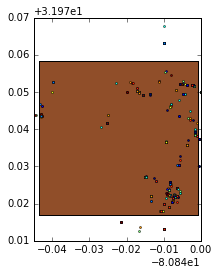

In [86]:
x.plot()

### Test that these are working as we hope?

In [89]:
feat_coll = {"type":"GeometryCollection","geometries":[]}
for idx, t in sav_tweets.sample(1000).iterrows():
    feat_coll['geometries'].append(t.geojson)
json.dump(feat_coll, open("/data/www/chime/sav_sample.geojson",'w'))

In [90]:
feat_coll = {"type":"GeometryCollection","geometries":[]}
for idx, t in tybee_tweets.sample(1000).iterrows():
    feat_coll['geometries'].append(t.geojson)
json.dump(feat_coll, open("/data/www/chime/tybee_sample.geojson",'w'))

http://www.townsendjennings.com/geo/?src=http://epic-analytics.cs.colorado.edu:9000/chime/sav_sample.geojson#13.01/32.0054/-80.8585

http://www.townsendjennings.com/geo/?src=http://epic-analytics.cs.colorado.edu:9000/chime/tybee_sample.geojson#13.01/32.0054/-80.8585

Write the tweets out as CSVs:

In [111]:
tybee_tweets['user'] = df.actor.apply(lambda actor: actor['preferredUsername'])

-c:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [112]:
sav_tweets['user'] = df.actor.apply(lambda actor: actor['preferredUsername'])

-c:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [113]:
rows = ['postedTime','user','body','link','geojson','verb']

In [114]:
tybee_tweets[rows].to_csv('/data/chime/matthew/locations/tybee_geo.csv')

In [128]:
sav_tweets[rows].to_csv('/data/chime/matthew/locations/savannah_geo.csv')